Código descoberto até agora:
```.cpp
const char* matriz_base[3][3] = {{1,2,3},{4,5,6},{7,8,9}};  //Esqueci como é a syntax
const char* var1 = ??
const char* var2 = ??

BOOL reset_matriz( (const char*)var1[3][3] ) {
    for(int i = 0; i <= 2; i++){
        for(int j = 0; j <= 2; j++){
            var1[i][j] = matriz_base[i][j];
        }    
    }
    return TRUE;
}

game( (const char*)var1[3][3] ) {
    while (true){
        system("cls");
        //
        system("pause");
    }
}

int main(void){
    srand(time(nullptr));
    reset_matriz(var1);
    reset_matriz(var2);
    game(?);
    return 0;
}
```

 Iremos acompanhar o workflow dos programas referentes ao projeto final da disciplina IMD1012, avaliando o código em assembly com os softwares x64dbg, Ghidra e Process Hacker. Começando com o tictactoe.exe, cuja função main esta definida no .cpp como:

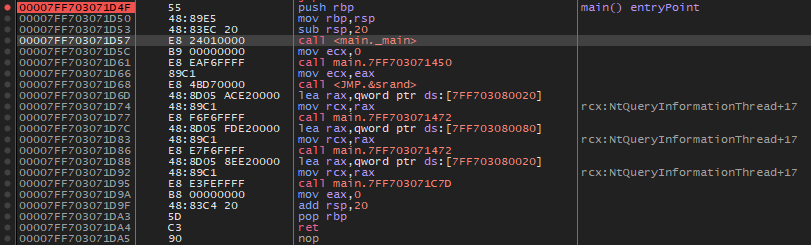

 Podemos encontrar o início do código ao buscar por chamadas de funções de uso comum, no caso do contexto do projeto, pela função printf() da stdio.h. A qual possui assinatura  __stdio_common_vfprintf, vindo da dll ucrtbase. E um pouco abaixo podemos notar algumas chamadas de funções a time, rand e srand, o que permite inferir algum tipo de aleatoriedade com seed dependendo do tempo atual. 

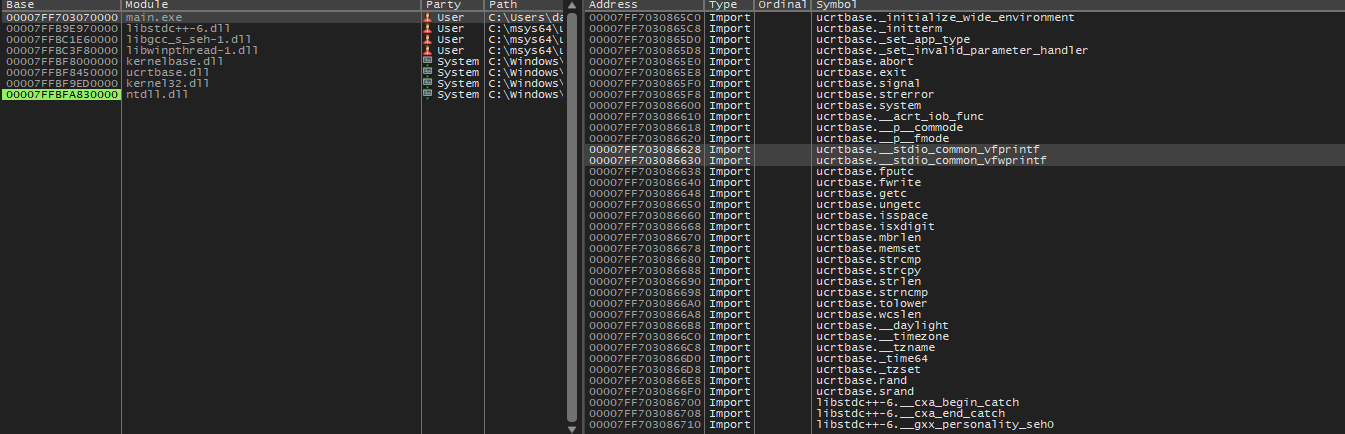

O uso de strcmp, strlen, strcpy e strcmp pode implicar algum tipo de manipulação de strings no codigo, poderiamos contar quantas chamadas ocorreram mas ainda não implementei um hook dinâmico para qualquer função e digamos que strcmp, por exemplo, é um tanto quanto grande (Não que isso influencie mas a diferença de tamanho pode provavelmente atrapalhar com a estrutura atual do dllhook).

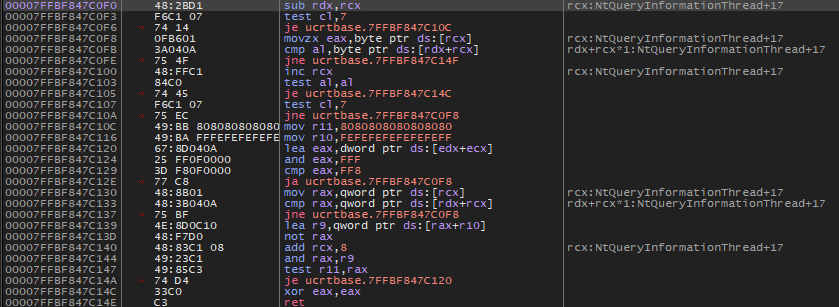

 Outra forma mais rápida de encontrar a função main (Ainda não descobri como fazer isso com o x64dbg) é com o Ghidra, o qual com as configurações iniciais de interpretação e análise é possível encontrar facilmente o início do código do tictactoe.exe. Dentre as coisas interessantes, o registrador ecx é usado como o argumento de funções (_Argc) e o eax é utilizado como return value de funções. 


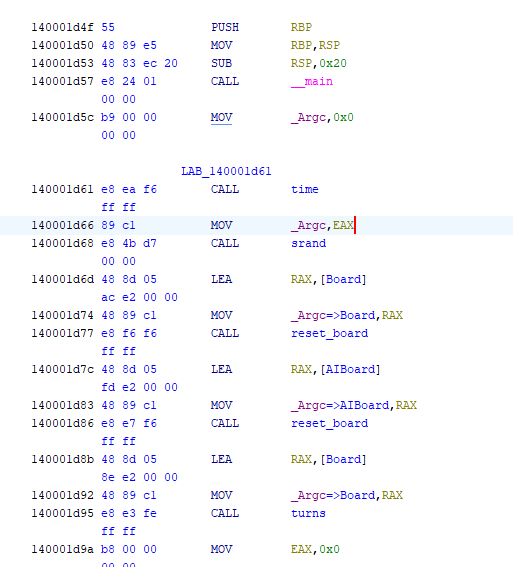

Na instrução: E8 EAF6FFFF | CALL time  ou  call main.7FF703071450, temos a chamada da função time que aponta pra uma função importada dentro de main que realiza uma call da função que inicia no endereço _time64, a qual está na lista de símbolos definido como 7FFBF8477F50, um endereço dentro da ucrtbase.dll a qual contém o código para a função time(). Provavelmente como rcx está nulo deste o início de main(), a função da ucrtbase deve usar 0 como nullptr (Tendo ciência da documentação sobre time(LPVOID) https://cplusplus.com/reference/ctime/time/), o que é uma equivalência que faz sentido porém ainda não tinha encontrado um exemplo.

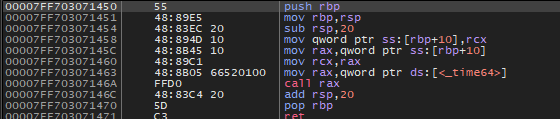

Quanto a função _time64 da header time.h, cuja definição está no ucrtbase.dll. Realiza uma chamada da GetSystemTimeAsFileTime
uma função da kernelbase.dll (A qual aparentemente não chama nada da ntdll, o que é bem estranho) localizada no endereço 7FFBF8059600. 

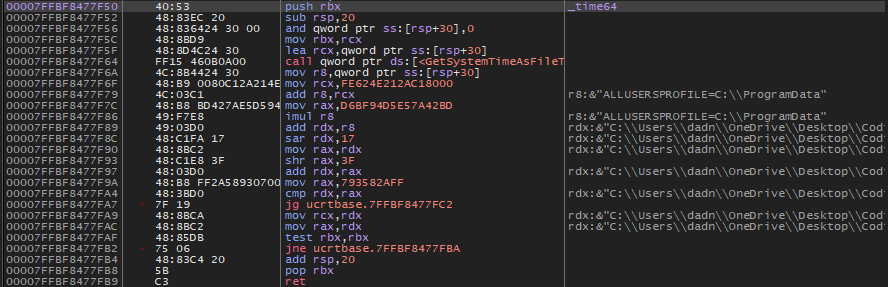

O endereço que está sobrescrito em 7FFBF8059600: 

00007FFBF8059600 | B8 1400FE7F           | mov eax,7FFE0014                            |

00007FFBF8059604 | 7F 48                 | jg kernelbase.7FFBF805964E                  |

que aparecem caso você chegue nesse endereço sem utilizar a call da _time64. Não tenho certeza do porque apenas parte da instrução é pega pra GetSystemTimeAsFileTime enquanto o bloco acima possui um hexcode CE | ???. Provavelmente por um problema do x64 em identificar qual bloco é de qual.

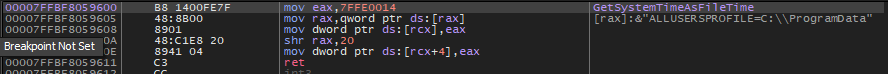

 E o endereço 7FFE0014 esta registrado como parte da alocada 7FFE0000 de descrição KUSER_SHARED_DATA, do tipo de alocação PRV (Private), tipo de acesso ReadOnly onde está sendo atualizado com as passagens de segundos no endereço acessado por GetSystemTimeAsFileTime. Na imagem abaixo, (64 23 05 9E EA C2 DA 01) aparentemente está contando as frações de segundo nos três primeiros endereços, no quarto os segundos, no quinto os minutos e acredito que os seguintes sejam horas, dias, anos e afins. (Poderia modificar o valor das variáveis para testar isso com time(nullptr) mas acredito nisso depois de ver o dos minutos subindo)

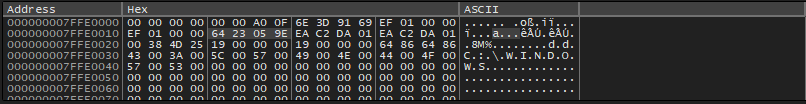

 E tentando caçar com o Ghidra os lugares que referenciavam esse endereço encontrei um problema, o programa não está identificando o endereço da _time64. Claramente tem algo que não estou sabendo fazer pois o código compilou e tudo necessário para o programa rodar tem que estar carregado. A menos que as dll por algum motivo absurdo sejam chamadas por fora...

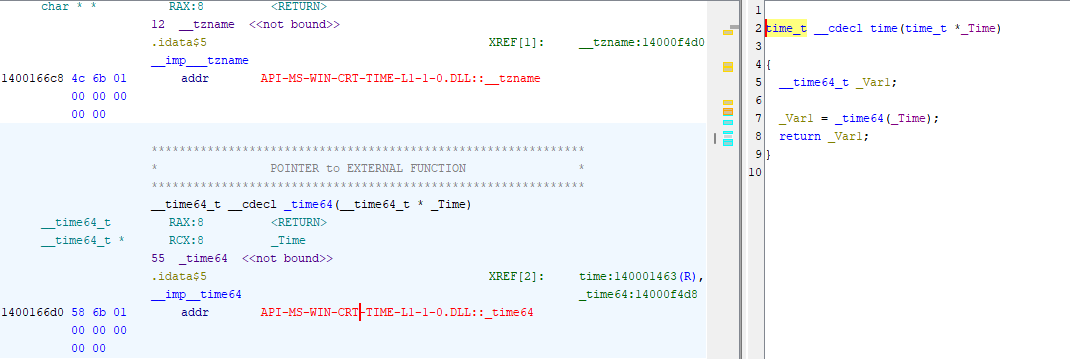

E abaixo o fluxograma dos jumps condicionais:

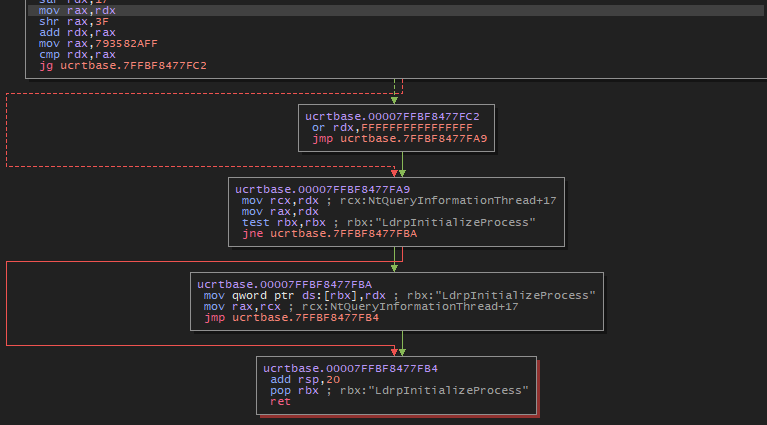

 Ou seja, ao fim de todo esse processo call main.7FF703071450 retorna o valor do tempo atual em eax, passa pra ecx e realiza um call para JMP.&srand, a qual aponta para um endereço com instrução jmp qword ptr:[\<srand>] que aponta para o endereço 7FFBF8456120. Após ficar saltando na memória do processo, chegamos a mais uma chamada da ucrtbase...

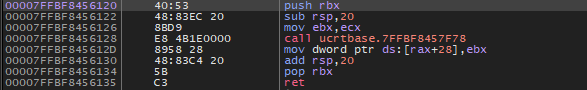

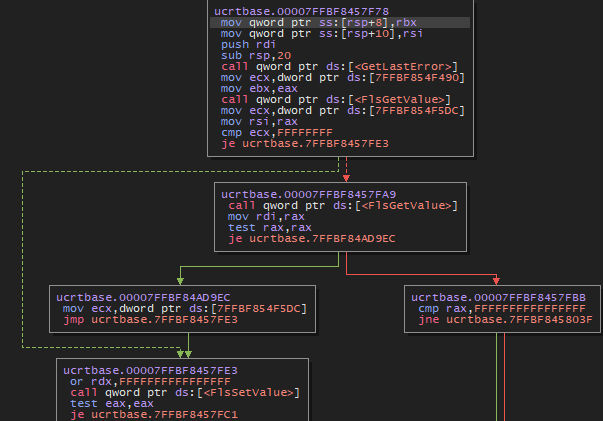

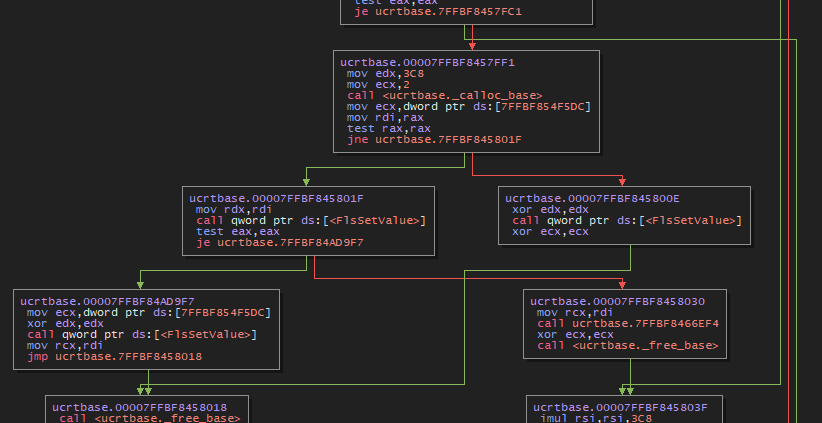

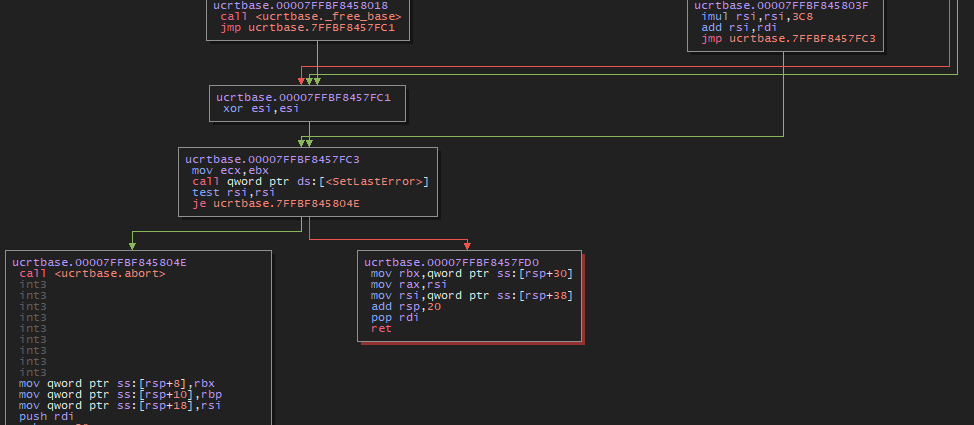

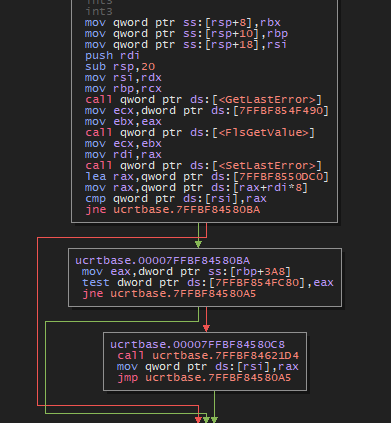

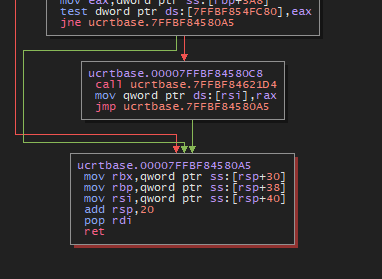

 E não irei nem mesmo começar a comentar sobre a lógica desse fluxograma... Tem chamadas da GetLastError(), mais misterioso que qualquer coisa (Tem tanto código no meio que me faz ficar incomodado, mas ainda sim não existe nenhum código aleatório no meio e com a seed do time(nullptr) tem de ser possível calcular o output de srand(), um dia faço uma análise mais profunda sobre e preparo pra realizar algum exploit). 
 
 Uma curiosidade aleatória rbx e rsp são do tipo stack e está sofrendo push e pop quando algumas funções iniciam e finalizam, acredito que eles estão guardando alguma informação a respeito das funções que estão a rodar no momento do código. (Em primeiro momento achava ser relacionado ao endereço delas mas ainda não descobri o que eles estão fazendo.)

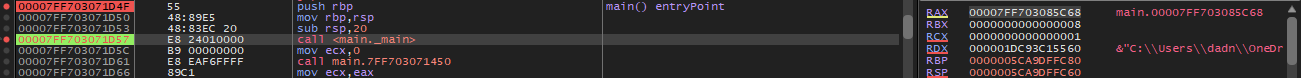

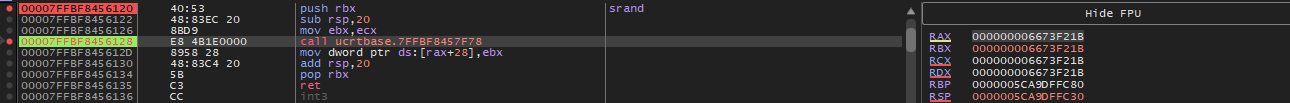

E então voltando ao main, estamos agora no endereço 7FF703071D6D | lea rax, qword ptr ds:[7FF703080020], um endereço de memória na secção .data de main.exe.

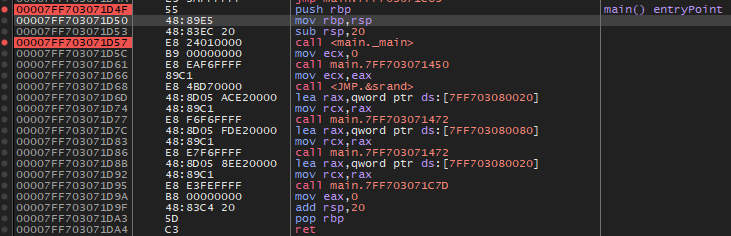

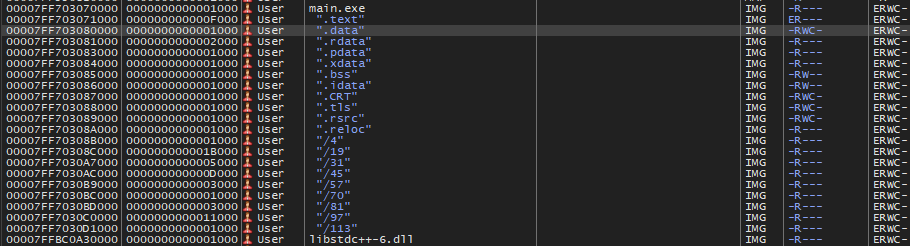

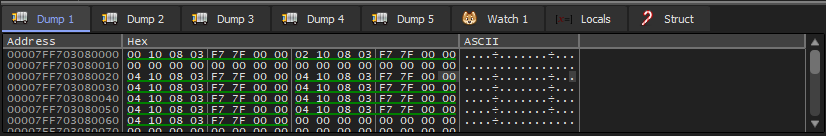

Esses endereços estão guardando ponteiros para outras partes do código e o endereço 00007FF703081004 está na secção .rdata de main.exe:

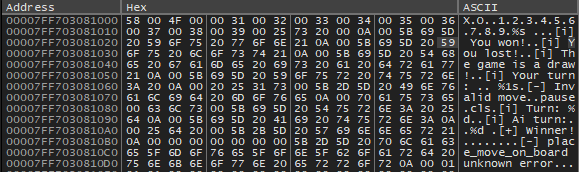

E descobrimos então que .rdata é onde as strings que aparecem no programa ficam guardadas! De imediato podemos separar as strings presentes em:

X, O, 1, 2, 3, 4, 5, 6, 7, 8, 9, %s (Ou seja, .rdata guarda o conteúdo bruto dos argumento de printf), \[i] You won!, \[i] You lost!, \[i] The game is a draw!, \[!] Your turn:, %1s, \[-] Invalid move, pause, cls, \[i] Turn: %d, \[i] Ai turn: %d, \[+] Winner!, \[-] place_move_on_board unknown error.

Nas linhas seguintes estão salvas outros outputs relacionados as mensagens de error de funções que estão sendo usadas internamente. Tendo encontrado as strings, podemos ter uma visualização geral do programa como um jogo da velha, com os símbolos X, O sendo os marcadores do tabuleiro e 1,2,3,4,5,6,7,8,9 sendo utilizado para representar o tabuleiro, algumas mensagens informando quem ganhou/perdeu e se empatou e uma informando o usuário para realizar uma jogada, também podemos inferir a existência de alguma IA que faz movimentos e provavelmente uma função com nome place_move_on_board. Com os %s, %1s, %d e %d, podemos inferir que o programa printa alguma variável (Seja os lances ou alguns contador) ou, provavelmente, o scanf() da stdio.h utiliza do mesmo endereço de memória que printf e essas variáveis indicam o tipo de input ( scanf("%1s", var) ). 

Em resumo, o valor que 7FF703081004 guarda é 00, o que provavelmente será acessado na função em 7FF703071472. Continuando com o fluxograma:

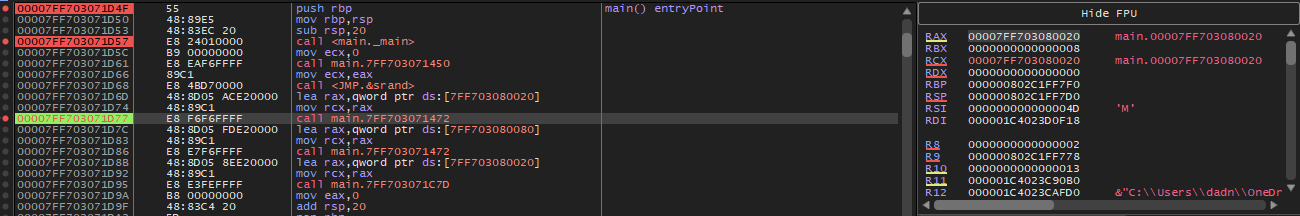

Com argv recebendo o endereço 7FF703080020, localizado em .data de main.exe, teremos a gigantesca função:

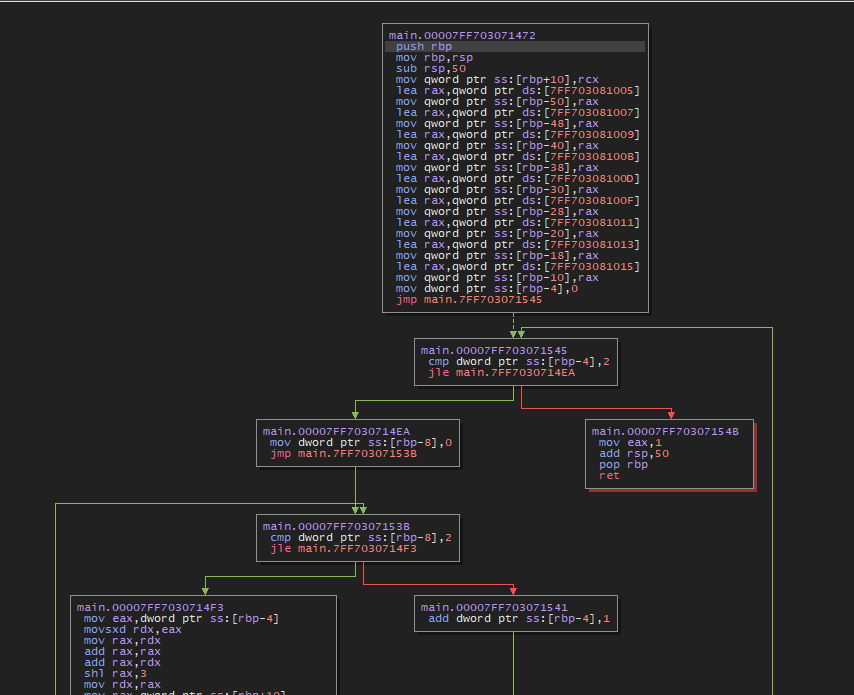

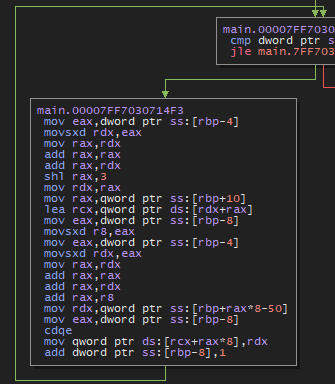

Quanto o primeiro bloco, carregamos os valores de string em todas os endereços de .rdata referentes aos algarismos 1,2,3,4,5,6,7,8 e 9 no stack rbp de base 802C1FF7C0, no qual começamos a escrever os endereços no offset -50 (sub rsp, 50) e guardamos na base (rbp) o antigo rsp (pointer para o topo do stack). Ao fim de tudo um jump incondicional para o próximo bloco de instruções, agora com os números 1-9 carregados da memória para uso.


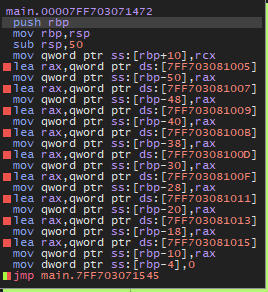

E abaixo um dump do stack rbp 802C1FF7C0, o qual eu não estava acompanhando até esse momento e de imediato uma coisa estranha: O endereço que aponta para o endereço de .rdata que contém as strings, 7FF703080020 de .data está no stack rbp em 802C1FF7D. Essa instrução foi adicionada com os comandos lea rax, qword ptr ds:\[7FF703080020] mov qword ptr ss:\[rbp+10], rax logo no início de 00007FF703071472 (No caso mov rcx, rax em 7FF703071D74). Apesar de ainda não ter sido utilizado para nada... em 802C1FF7C8 contém para onde o programa deve retornar ao fim do call (A propriedade de call address: pushes value of rbp and rip onto stack before jumping, isto é, da um push do endereço no rip pra dentro do rbp). E em 802C1FF7F0 está o endereço do executável. 

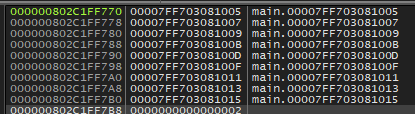

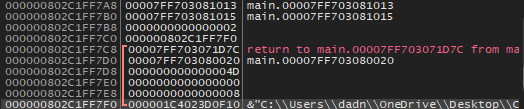

Uma coisa interessante é a existência de vários stacks no memory map... Como não acompanhei até o momento o surgimento deles, não da pra saber exatamente de onde eles vieram.

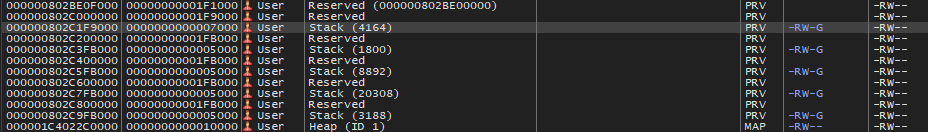

Quanto o segundo conjunto de blocos, uma série de condições:

Em main.7FF703071545 comparamos \[rbp-4] (que é igual a zero inicialmente) com 2 e pulamos para main.7F7030714EA se o primeiro for menor igual a 2, caso contrário, pulamos para main.7FF70307154B.

Em main.7FF70307154B movemos 1 para eax, indicando um return 1; adicionamos a rsp 50, desalocando o endereços de rbp onde 0-9 de .rdata estão salvos; realizamos um pop rbp para então tirar o valor e o endereço no topo de rbp (O endereço de main.exe); Então finalizamos a função com ret.

Em main.7F7030714EA movemos ao endereço rbp-8 o valor 0, o qual é o endereço 802C1FF7B8 cujo valor inicial é zero; Seguido por um jmp incondicional para main.7FF70307153B.

Em main.7FF70307153B comparamos \[rbp-8] (que é igual a zero, setado na última função) com 2 e pulamos para main.7FF7030714F3 se o primeiro for less/equal que 2, caso contrário, pulamos para main.7FF703071541.

Em main.7FF703071541, adicionamos a \[rbp-4] 1 e voltamos para main.7FF703071545.

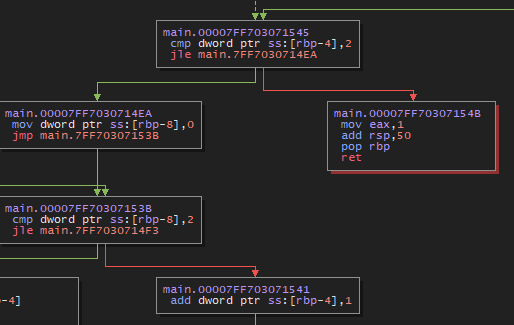

Em main.7FF7030714F3 ocorre uma sequência de eventos:

Pegamos o valor de \[rbp-4], o qual contém algum valor entre 1, 2 ou 3 e salvamos esse num endereço de 8bytes rdx.

Movemos para rax o endereço rbp+10, o elemento do stack que aponta para 7FF703080020, aquele parâmetro que não estava sendo utilizado.

Passamos para rcx o endereço soma \[rdx+rax], primeiro movendo para rax o valor em \[rbp+10], o qual guarda o endereço da função 7FF703080020 (Inserida em rbp logo no início da função). Como rdx começa com 0 na primeira iteração, nada ocorre e rcx = rax.

Movemos para eax o valor em \[rbp-8], um valor igual a 0, 1 ou 2, passando para r8 com tamanho 8bytes. O mesmo para \[rbp-4], porém o movendo ao registrador rdx. (Como ambos começam com zero, rax e r8 ficam igual a zero).

Em seguida, após algumas transportações de memória, movemos para rdx o valor em \[rbp + rax*8 - 50], que justamente ficará iterando entre os endereços de rbp de 802C1FF770 até 802C1FF7B0. Isso é, com as 3 iterações totais de \[rbp-4] e \[rbp-8] acessaremos os 9 endereços em rbp que guardam os endereços em .rdata das strings de 0-9. Com essa informações, podemos inferir que rax ao fim das diversas operações acima guarda o valor de \[rbp-4]*3+(\[rbp-8]+1).


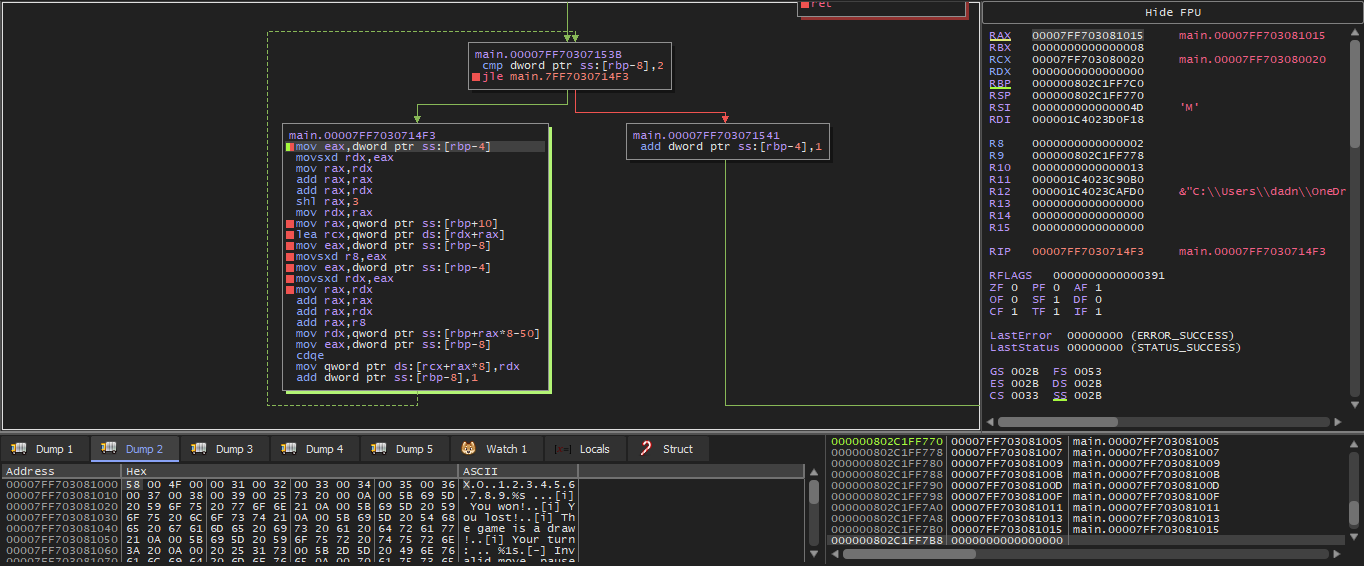

Na segunda metade da função, movemos para \[rcx+rax\*8], que é um endereço em .data de main.exe, o valor de rdx (endereço para alguma string em .rdata) e então incrementamos \[rbp-8] em 1, retornando para a main.7FF70307153B. Podemos verificar as variáveis com o dump de .data (Lembrando que na primeira iteração, rax\*8=0)

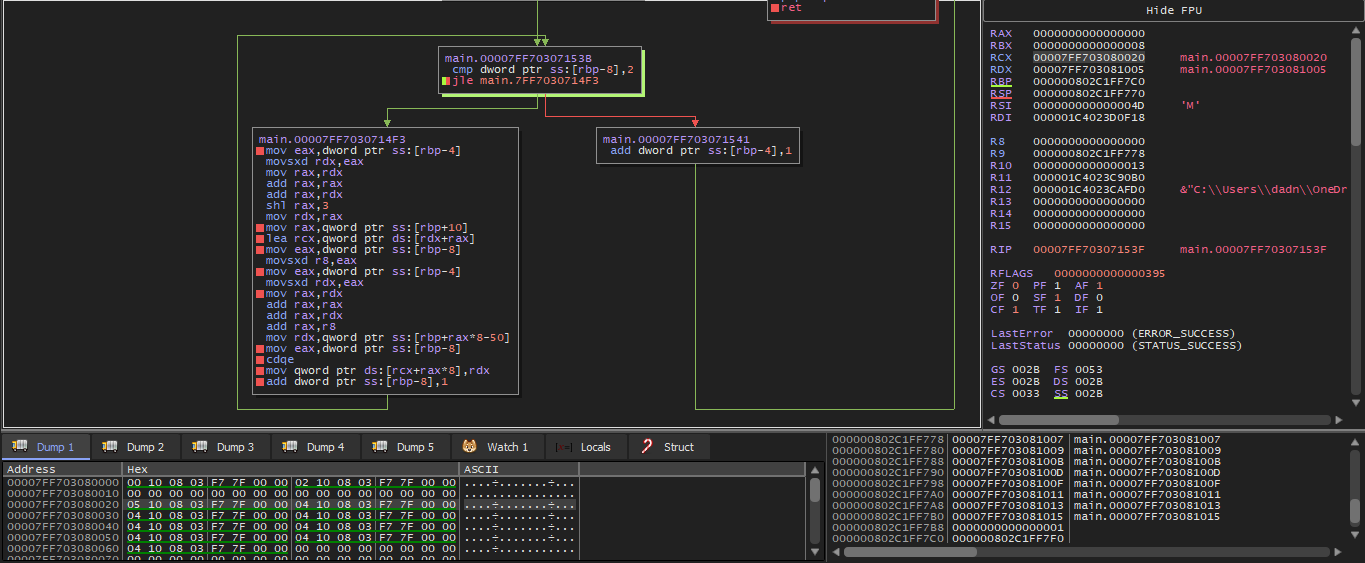

Após as 9 iterações, o endereço das constantes 0-9 foram escritas em .data, podemos notar no dump1 o stack de base 7FF703080020 de .data com os endereços do stack temporário de base 802C1FF7C0 de informações sobre .rdata. E ao chegamos no ret o qual retorna a execução no main().


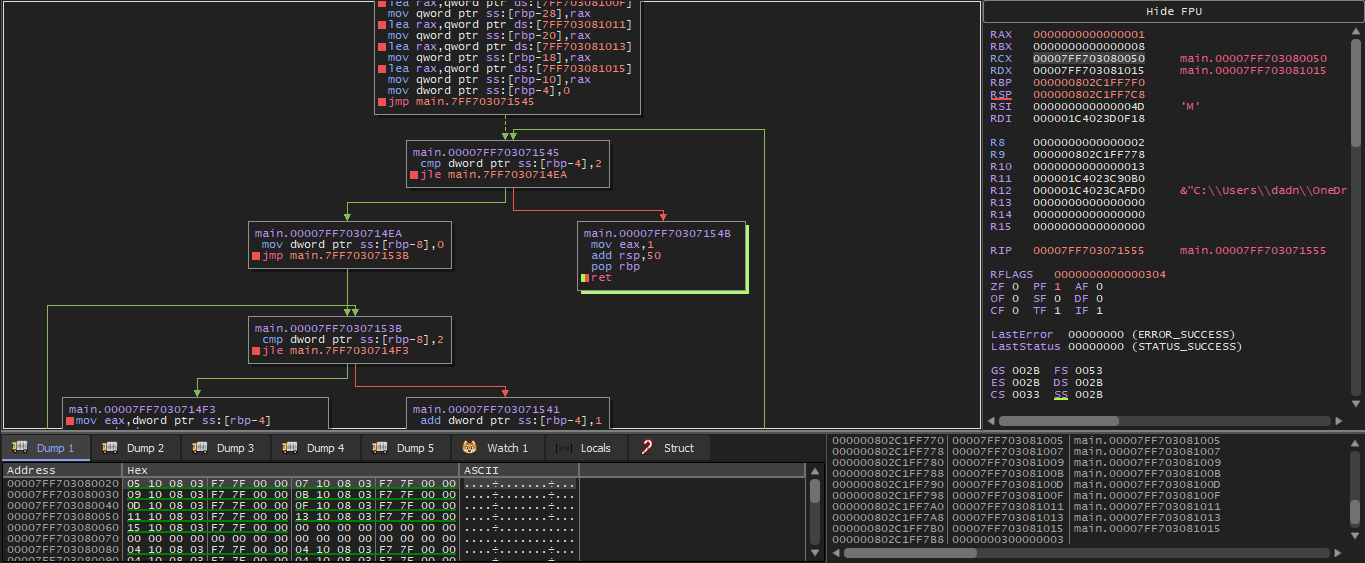

Em seguida a mesma função é chamada novamente, desta vez com um novo parametro rcx = 7FF703080080, repetindo o mesmo processo descrito acima e escrevendo em um endereço de .data de main.exe. Ou seja, podemos interpretar essas chamadas como inicialização de uma variavel que utiliza os digitos de 1 a 9, pela proximidade dos endereços e a utilização de stacks para tal, provavelmente uma matriz 

```
7FF703080020 = 
1 2 3
4 5 6
7 8 9

7FF703080080 =
1 2 3
4 5 6
7 8 9
```

Em seguida, a última função de main(), call.7FF703071C7D seguida de um return 0 e um pop rbp para limpeza de memória.


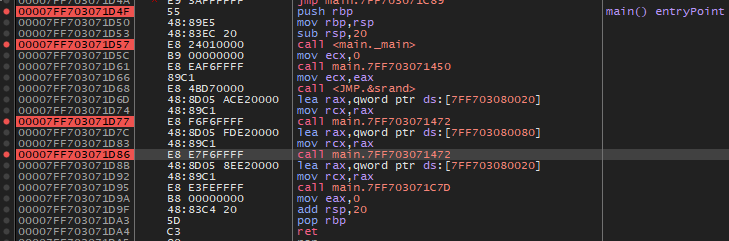

Provavelmente essa função irá utilizar as matrizes inicializadas nas últimas linhas. Começamos com o push de argc para \[rbp+10]:

Para mais informações: https://learn.microsoft.com/en-us/cpp/c-language/system-function?view=msvc-170, apesar da microsoft não elaborar muito sobre a natureza dessa função... Bem, em resumo, system passa ecx como string/command ao terminal cmd, o qual executa o comando se for válido. Ou seja, temos uma chamada de system("cls"); nessa linha!

Quanto as instruções seguintes, mov eax dword ptr ds:\[7FF703081081] passa o valor 1 pra eax, realiza mov edx, eax e então carrega mais uma string de .rdata, passando como argumento para call.7FF70307F780. Essa função chama __acrt_iob_func, a qual copia o endereço 7FFBF854F4A0 para rcx, realiza uma multiplicação rax*58, guarda em rax (Por que um endereço tão grande?) e add rax, rcx, ou seja, essa função retorna um endereço que envia o código para algum lugar 

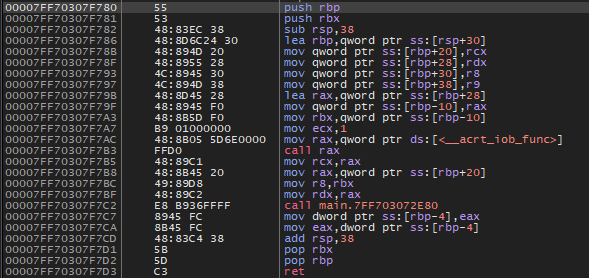

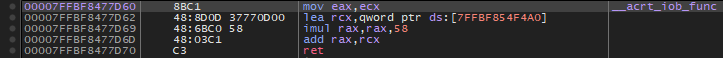

Acabei por reiniciar o PC e perdi os endereços de variáveis que estávamos a utilizar até o momento... Abaixo segue-se as imagens dos novos endereços:

Main()

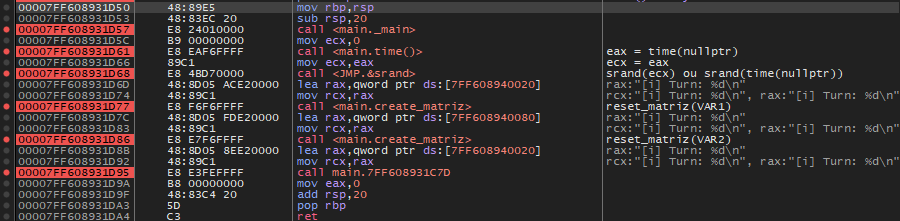

_main()

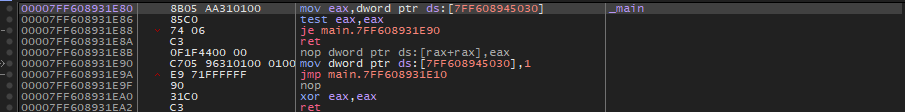

time()

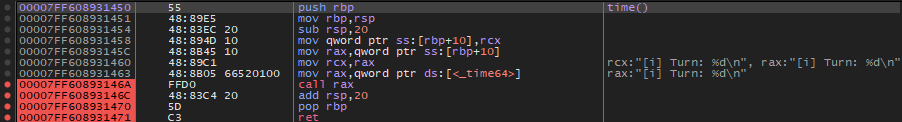

srand()

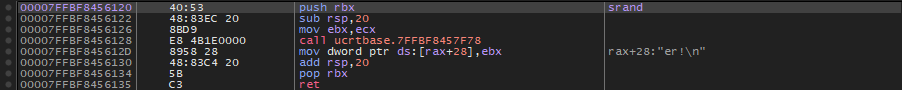

reset_matriz(const char* var1)

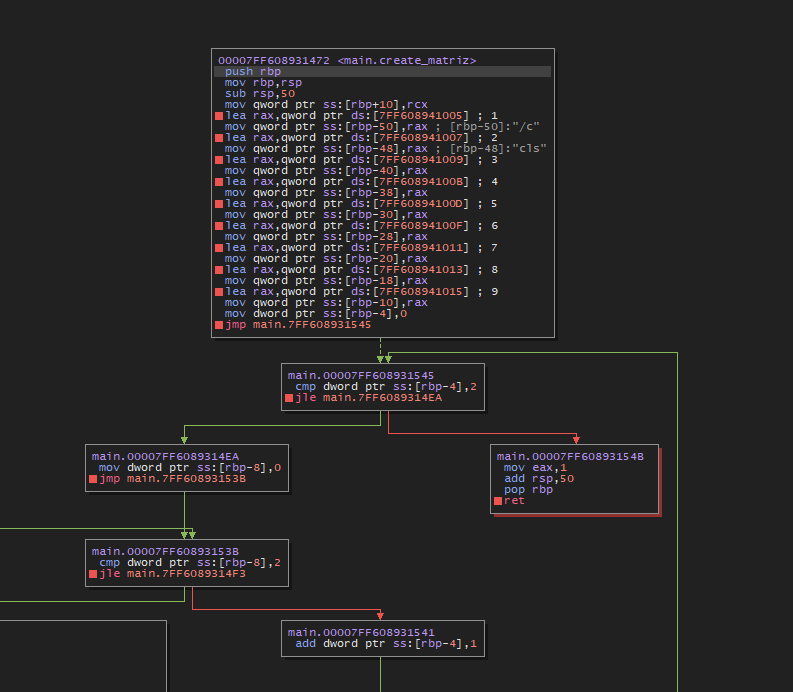

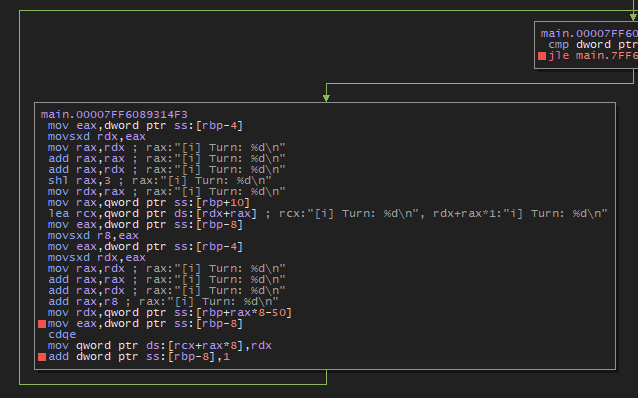

E quantos os valores e endereços das seções .data, .rdata, stacks e afins:

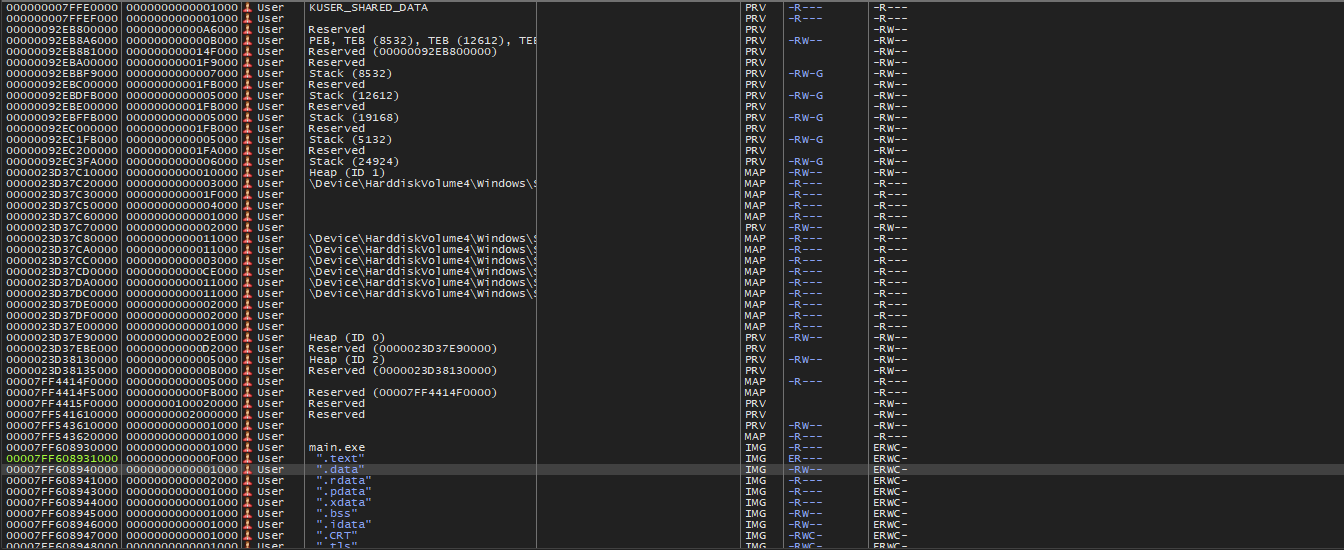

E continuando de onde paramos:

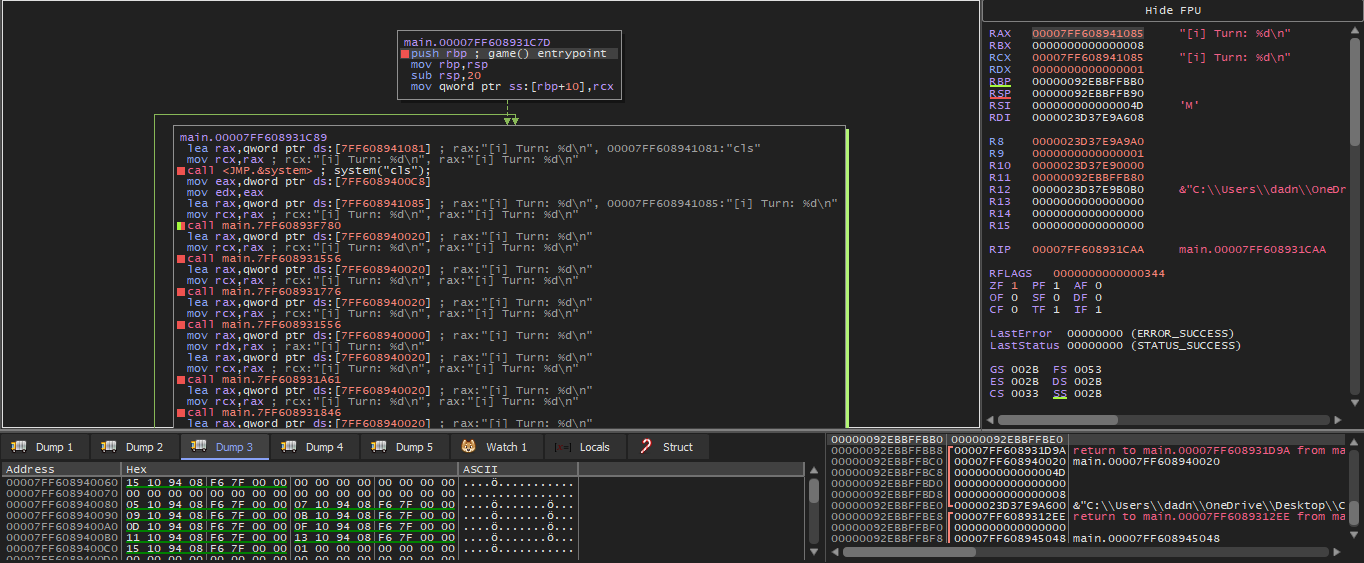

 E imediatamente a call da função &system com argc "cls" (string definida em .rdata de main.exe), seguido por uma chamada de diversas funções nativas de main.exe... Ignorando a JMP.&system, temos ao final do bloco o único jmp incondicional do bloco, indicando um loop infinito. Note que as instruções:
```asm
push rbp
mov rbp, rsp
sub rsp, 20
mov qword ptr ss:[rbp+10], rcx
```
Tem uma rotina que sempre está presente no workflow de funções, com push rbp; mov rbp, rsp; sendo os sempre presentes provavelmente devido a arquitetura da intel.

 Quanto a chamada da função declarada no endereço <JMP.&system> (Pula para um endereço que tem outro jump para \<system>, no qual outro jump para ucrtbase.7FFBF850D14C ocorre e no endereço final uma função bem pequena), com parâmetro 7FF608941081 cuja string em .rdata é "cls", realiza uma execução da string "cls" como um comando no interpretador cmd, isto é, equivalente ao system("cls")... Abaixo podemos ver o fantasma dessa função...

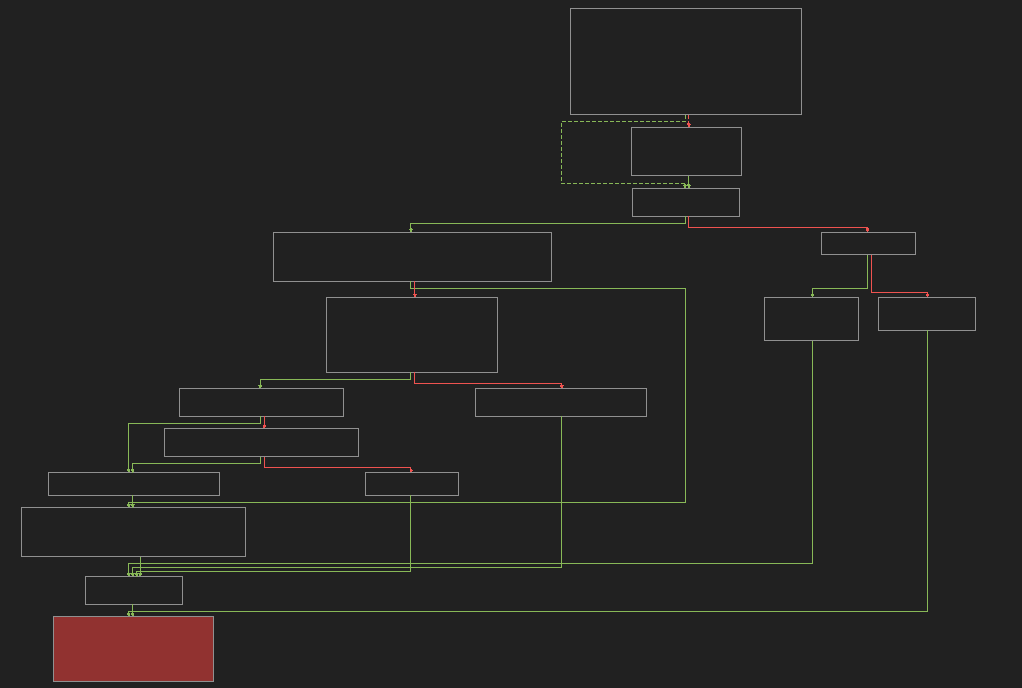

Um dia irei dissecar a fundo como a system(const char*) funciona mas, por enquanto, nos contentaremos com a documentação muito bem informada da Microsoft: https://learn.microsoft.com/en-us/cpp/c-runtime-library/reference/system-wsystem?view=msvc-160. Em seguida a função 7FF60893F780, de antigo endereço 7FF70307F780 recebe o valor que está salvo no endereço 7FF6089400C8 (Provavelmente uma variável global) em rdx e uma string de .rdata do endereço 7FF608941085 em rcx cujo valor é "\[i] Turn: %d\n". Provavelmente o \[i] se refere a algum contador, visto o loop incondicional existente (Alguma das funções deve conter o break que finaliza a game() e, consequentemente, o programa) e 7FF6089400C8 deve conter esse valor.

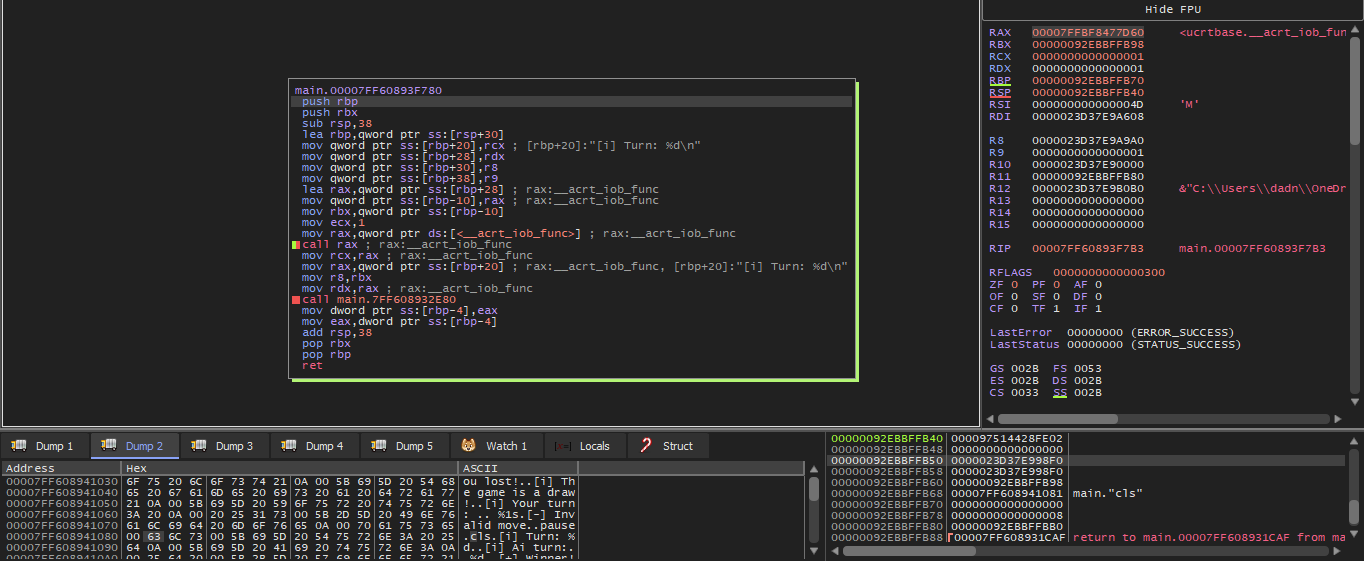

Na primeira parte do programa, diferentemente da usual push rbp; mov rbp, rsp; Ocorre a inicialização de dois stacks, rbp e rcx com um sub rsp, 38; provavelmente para alocação de mais endereços e escrevemos na base rbp novo endereço do rsp \[rsp+30]. Nas quatro linhas seguintes criamos 4 variáveis locais, uma para guardar a string passada por rcx, uma para guardar o valor int de rdx e os outros registradores utilizados para argumentos, r8 e r9, são guardados para uso local também.

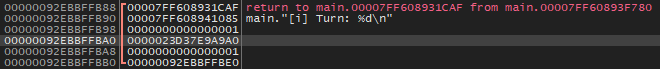

O valor que r8 carregava era 23D37E9A9A0 e r9 carregava 1. Interessante é pra qual região r8 está apontando, um heap de ID 0 cuja inicialização e chamada não aparecer até agora... Provavelmente relacionado a algum dos imports...

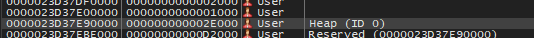


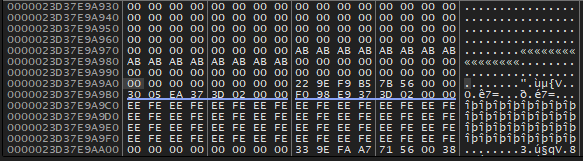

É interessante como a maioria desses endereços aleatórios apontam pra nenhum valor... Bem, agora com o stack rbp guardando todos esses parametros, rax recebe o endereço \[rbp+28], o guarda em 92EB8FFB60 e move este endereço para rbx. Na instrução seguinte o argumento ecx recebe 1 e uma chamada de __acrt_iob_func ocorre. Simbolo da ucrtbase.dll com assinatura definida em 7FFBF8477D60:

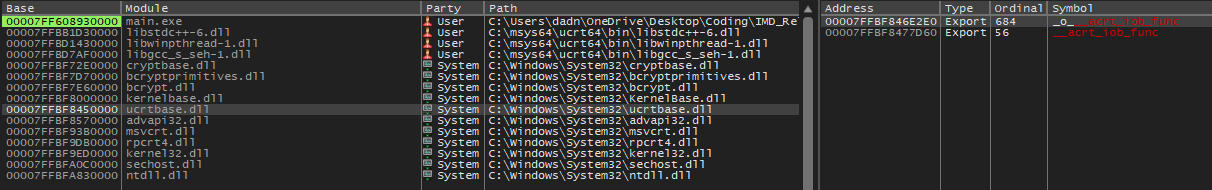

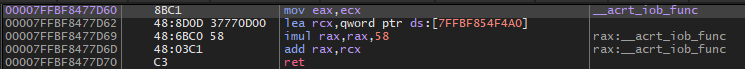

Neste bloco eax recebe ecx (=1), copiamos a rcx o endereço 7FFBF854F4A0 (Apontando para a seção .data de ucrtbase.dll) no qual também não temos nada mais que registradores com valores 0.

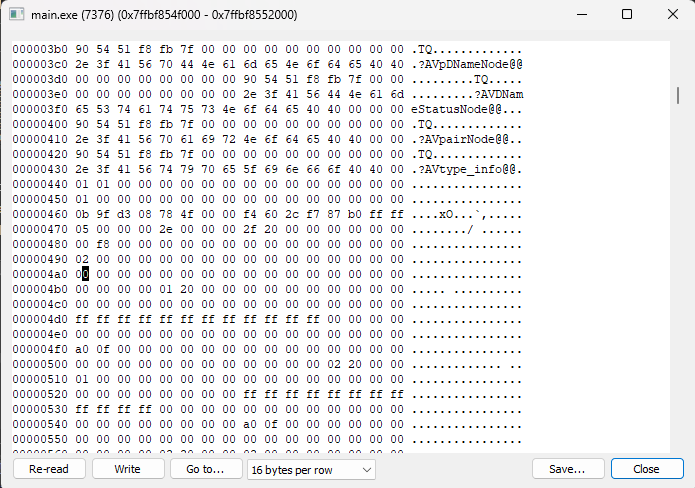

Ou seja, a rotina pega o valor salvo em rcx, multiplica por 58, move para rax, passa para rcx um endereço em .data de ucrtbase.dll e soma rcx com rax, salvando em rax com um novo endereço em .data ucrtbase.dll (Neste caso também aponta pra registradores com valor 0). Ou seja, a função simplesmente retorna um endereço de memória... Continuando a rotina:

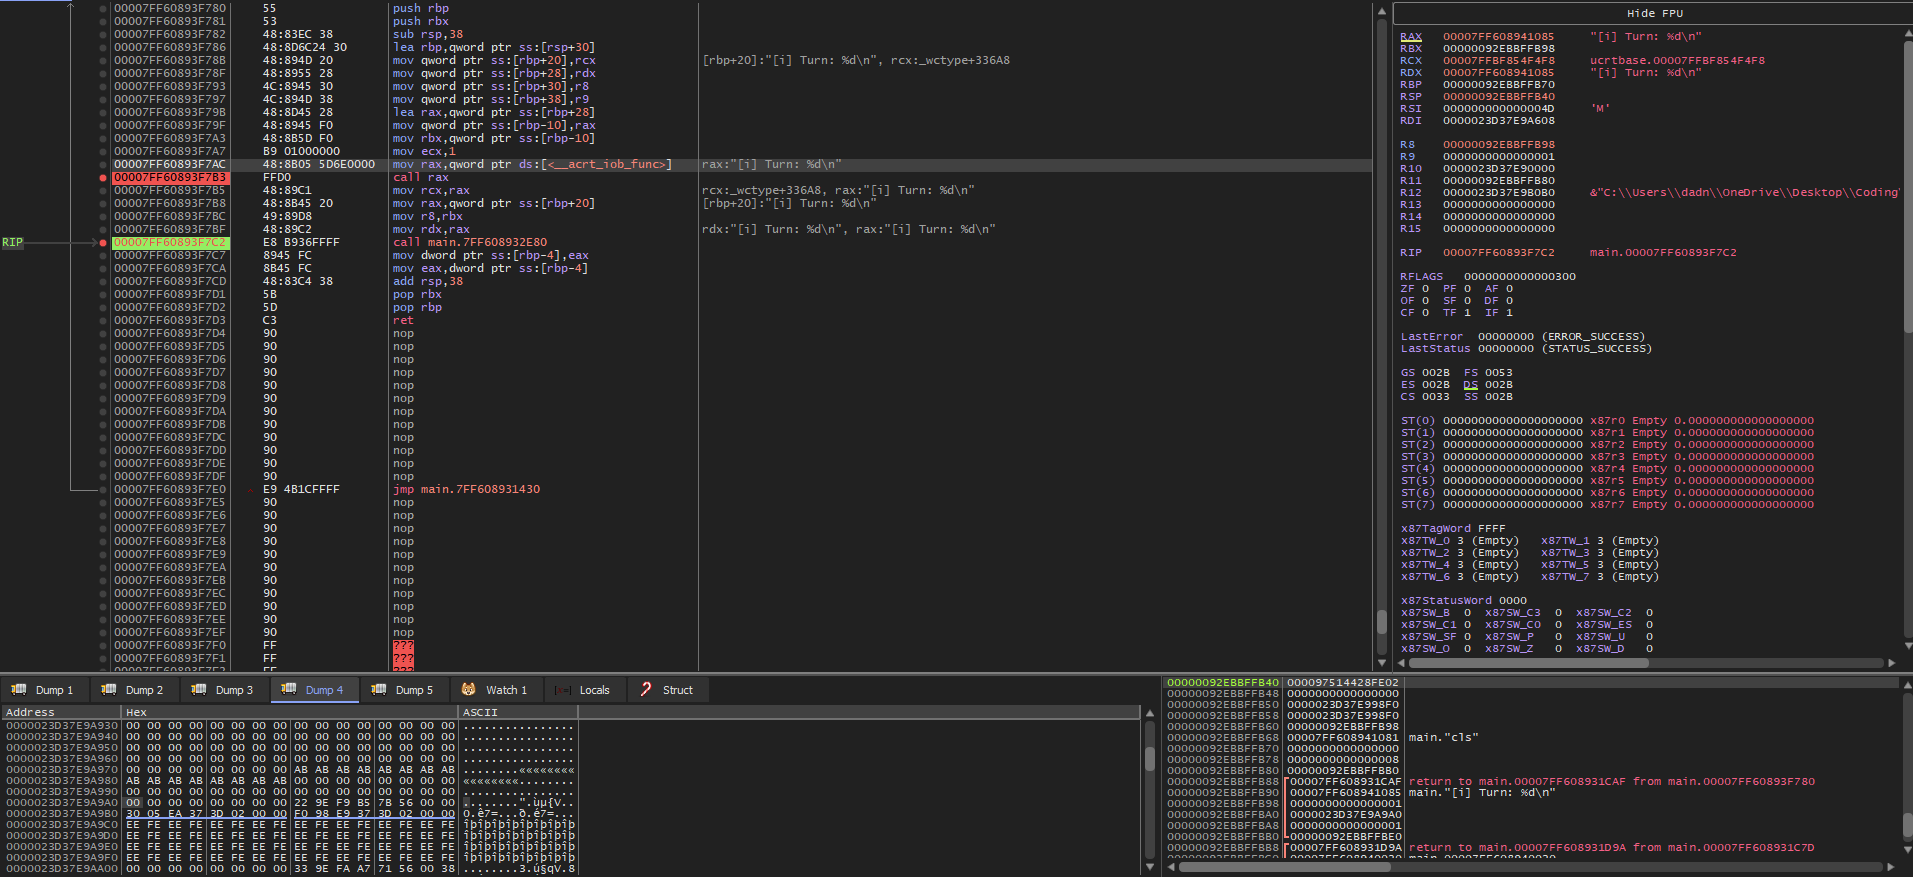

Movemos para rcx o endereço retornado por call \[__acrt_iob_func], movemos para rax e então para rdx o valor que esta em \[rbp+20], a string que foi passada como parametro inicial pra esta função e passamos para r8 o stack rbx, para então a chamarmos com estes parâmetros a função 7FF608932E80 nativa de main.

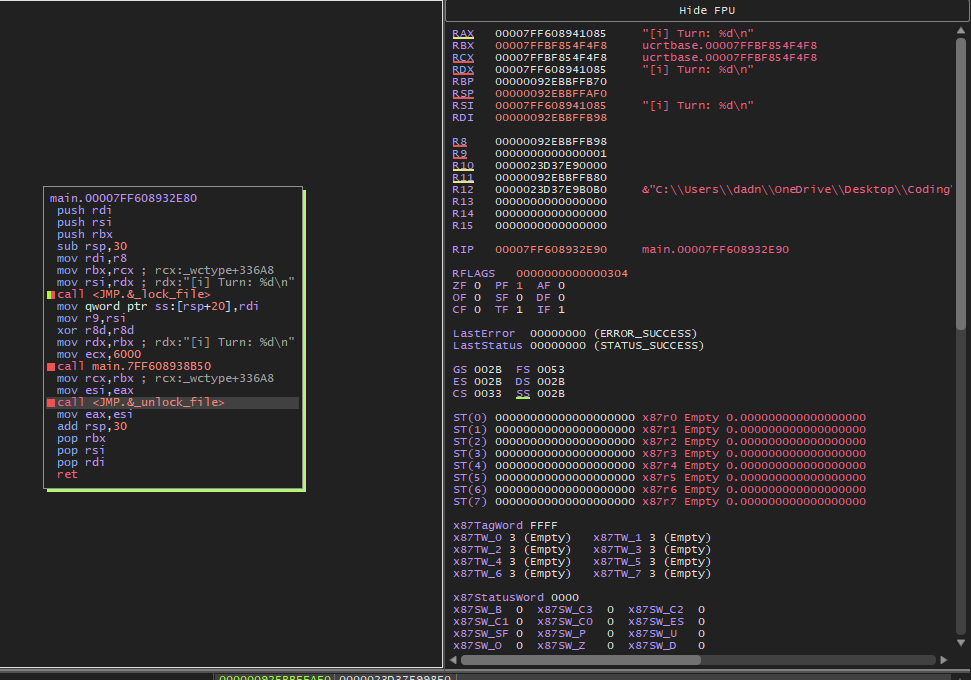

Essa função realiza dois calls de funções que até agora não tinha visto, &_lock_file e &_unlock_file... Além de já começar com push de 3 novos stacks, rdi, rsi e rbx, passamos para eles os parametros r8, rcx e rdx (Endereço do stack rbp onde o valor que esteva em 7FF6089400C8 foi copiado, o endereço aleatório em .data de ucrtbase.dll que foi retornado pela última função e rdx que guarda a string que esta guardada em .rdata de main.exe). Com tais parâmetros, realizamos a chamada da função definida em <JMP.&_lock_file>, também definida em ucrtbase.dll e aponta para 7FFBF84765A0, onde mais uma vez realizamos um jmp e chegamos a uma função da ntdll nova, RtlEnterCriticalSection, relacionada as permissões de acesso a Threads por PID (mov rax, qword ptr gs:\[30]) e não irei dissecar muito seu funcionamento. 

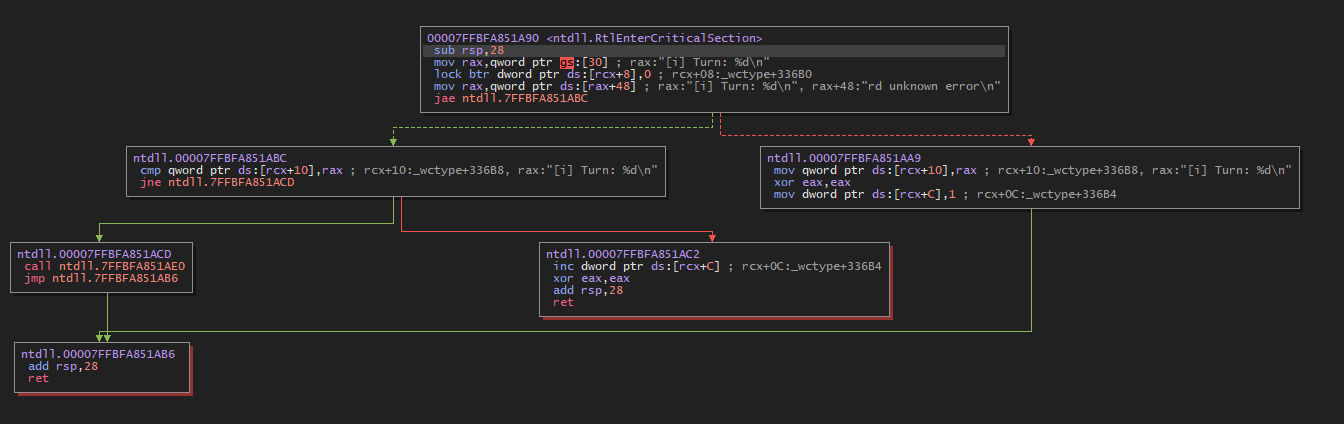

Quanto a proxima função, 7FF608938B50, recebe r9 com rsi (Contém a string "\[i] Turn: %d\n"), realiza um xor da parte down do registrador r8, recebe o endereço aleatório em ucrtbase.dll e rcx com 6000hex de parâmetros. Quanto o início da função:

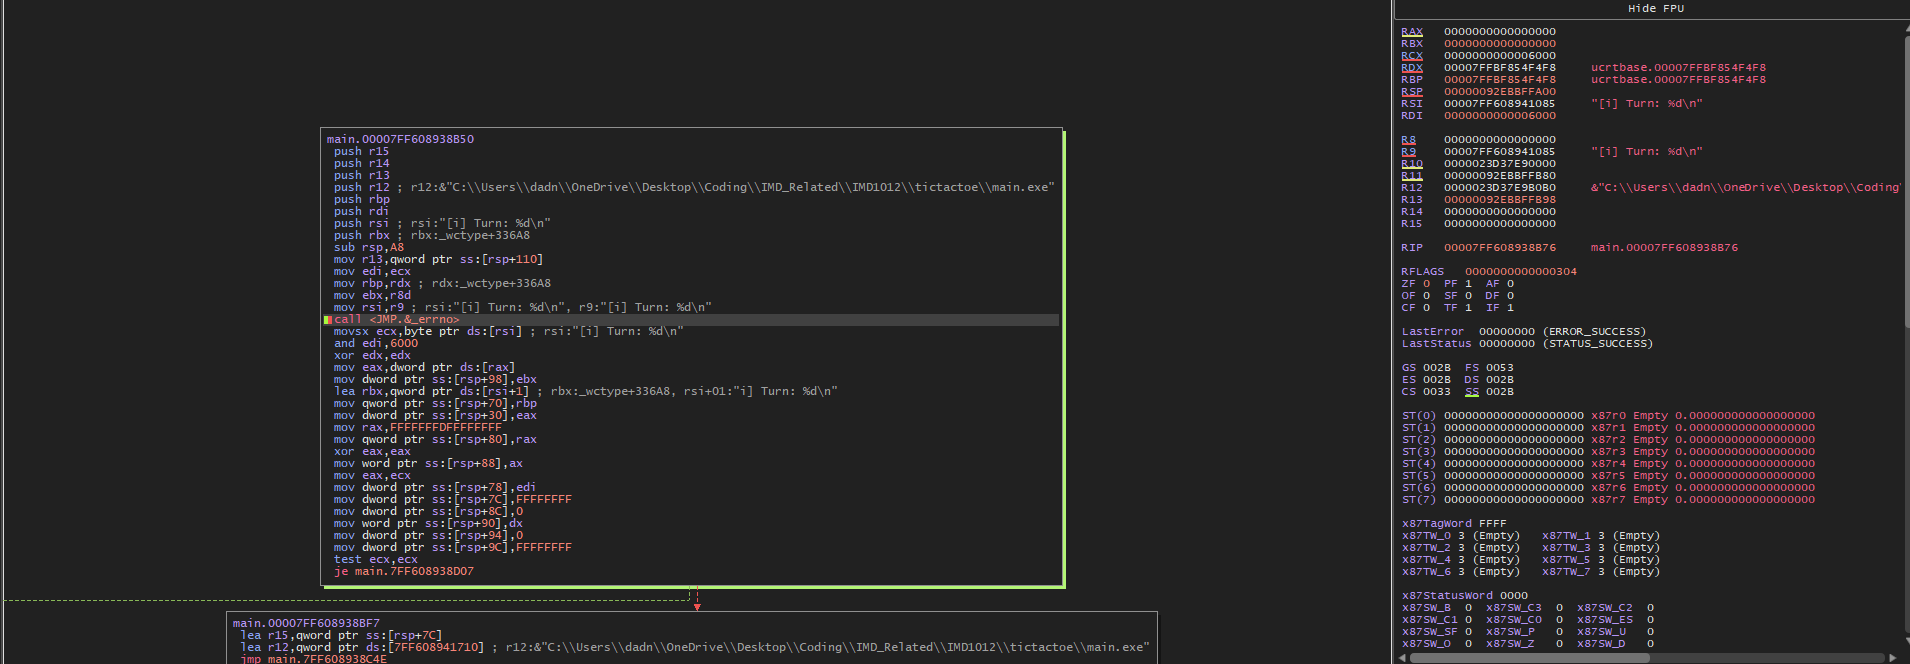

E de imediato notamos a presença de diversos stacks, r15, r14, r13, r12, rbp, rdi, rsi e rbx! Agora teremos:

r15 = null
r14 = null
r13 = 92EBBFFB98 (mov r13, qword ptr ss:\[rsp+10])